In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import utilities
import GCC_Preprocess as gpp
import pyHREBSD
import rotations

%matplotlib widget


def view(*imgs, cmap='gray', titles=None):
    n = len(imgs)
    fig, axes = plt.subplots(1, n, figsize=(3*n, 4))
    if n == 1:
        axes = [axes]
    for i, img in enumerate(imgs):
        ax = axes[i]
        ax.imshow(img, cmap=cmap)
        ax.axis('off')
        if titles is not None:
            ax.set_title(titles[i])
    plt.show()

In [ ]:
up2 = "E:/cells/CoNi90-OrthoCells.up2"
ang = "E:/cells/CoNi90-OrthoCells.ang"
pats, ang_data = utilities.get_scan_data(up2, ang, (2048, 2048), 13, calculate_sharpness=True)
pats = utilities.clean_patterns(pats, equalize=True)
print("Number of patterns:", pats.shape[0]*pats.shape[1])
print("Pattern shape:", pats.shape[2:])
print("Grid:", pats.shape[:2])
print("Pattern center:", ang_data.pc)

In [ ]:
T = pats
R = pats[112, 96]
subset_slice = (slice(R.shape[0] // 2 - 64, R.shape[0] // 2 + 64),
                slice(R.shape[1] // 2 - 64, R.shape[1] // 2 + 64))
p0 = gpp.GCC_Initial_Guess(R, T)
np.save("p0_r112-96.npy", p0)
p = pyHREBSD.get_homography(R, T, subset_slice=subset_slice, p0=p0, max_iter=50, conv_tol=1e-7)
np.save("p_r112-96.npy", p)
p0 = np.load("p0_r112-96.npy")
p = np.load("p_r112-96.npy")

In [ ]:
R = pats[112, 96]
T = pats[112-50:112+50, 96-50:96+50]

subset_slice = (slice(10, R.shape[0] - 10),
                slice(10, R.shape[1] - 10))

p0 = gpp.get_initial_guess(R, T)
np.save("p0_r112-96-small.npy", p0)

p = pyHREBSD.get_homography(R, T, subset_slice=subset_slice, p0=p0, max_iter=50, conv_tol=1e-7)
np.save("p_r112-96.npy-small", p)

# p0 = np.load("p0_r112-96.npy")
# p = np.load("p_r112-96.npy")


In [ ]:
Fe = pyHREBSD.homography_to_elastic_deformation(p, ang_data.pc)
e, w = pyHREBSD.deformation_to_strain(Fe)

W = np.zeros_like(Fe)
W0 = np.zeros_like(Fe)
for i in range(Fe.shape[0]):
    for j in range(Fe.shape[1]):
        W[i, j] = pyHREBSD.W(p[i, j])
        W0[i, j] = pyHREBSD.W(p0[i, j])

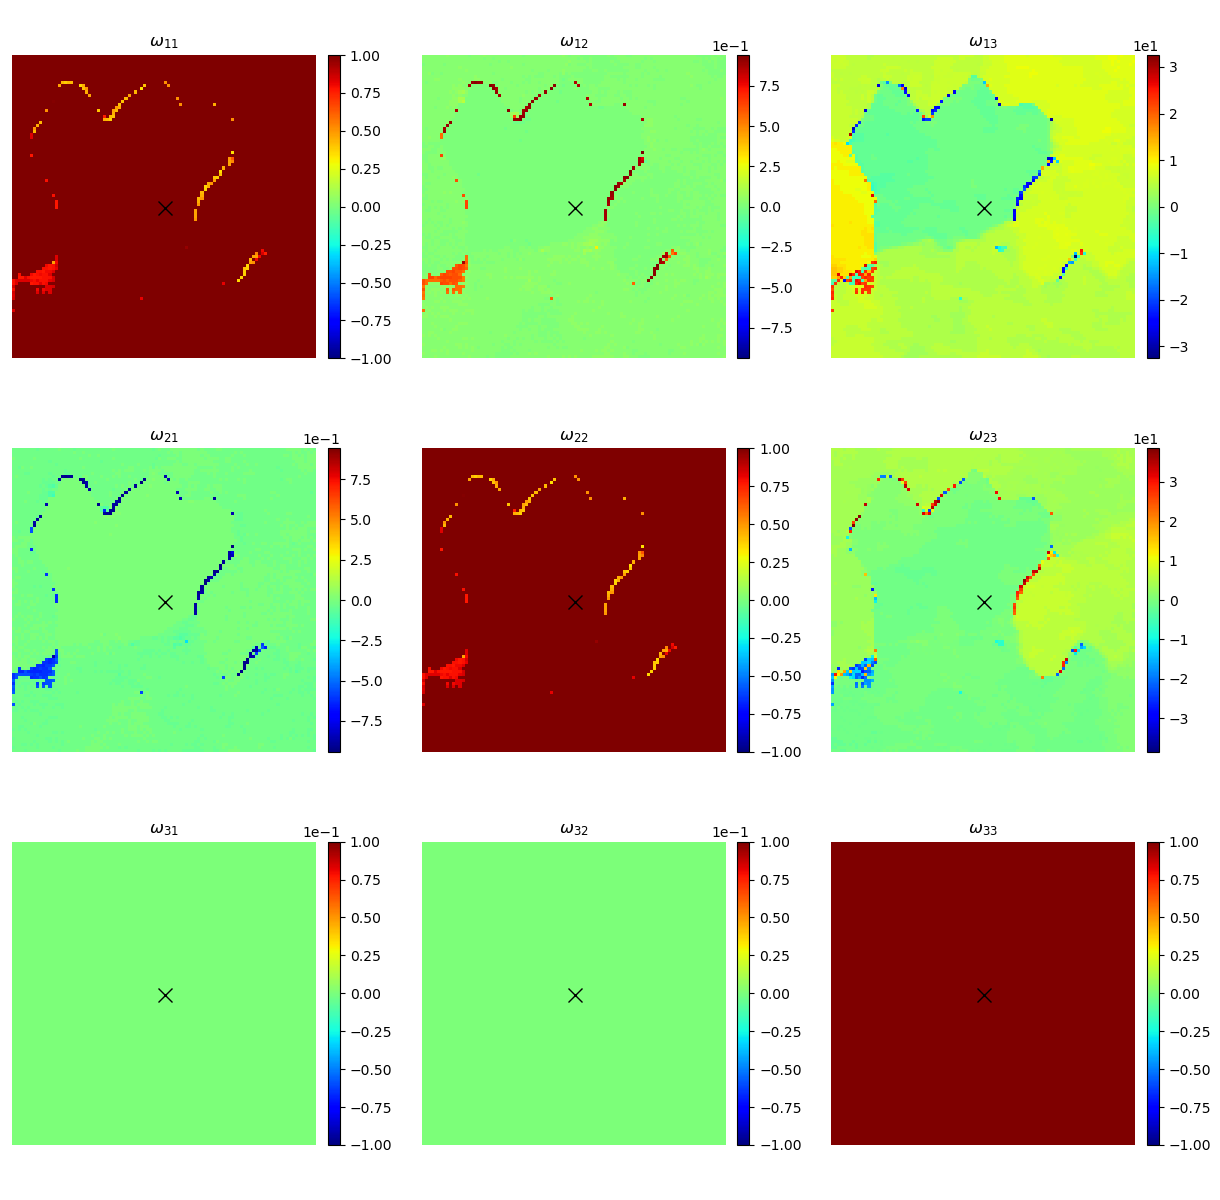

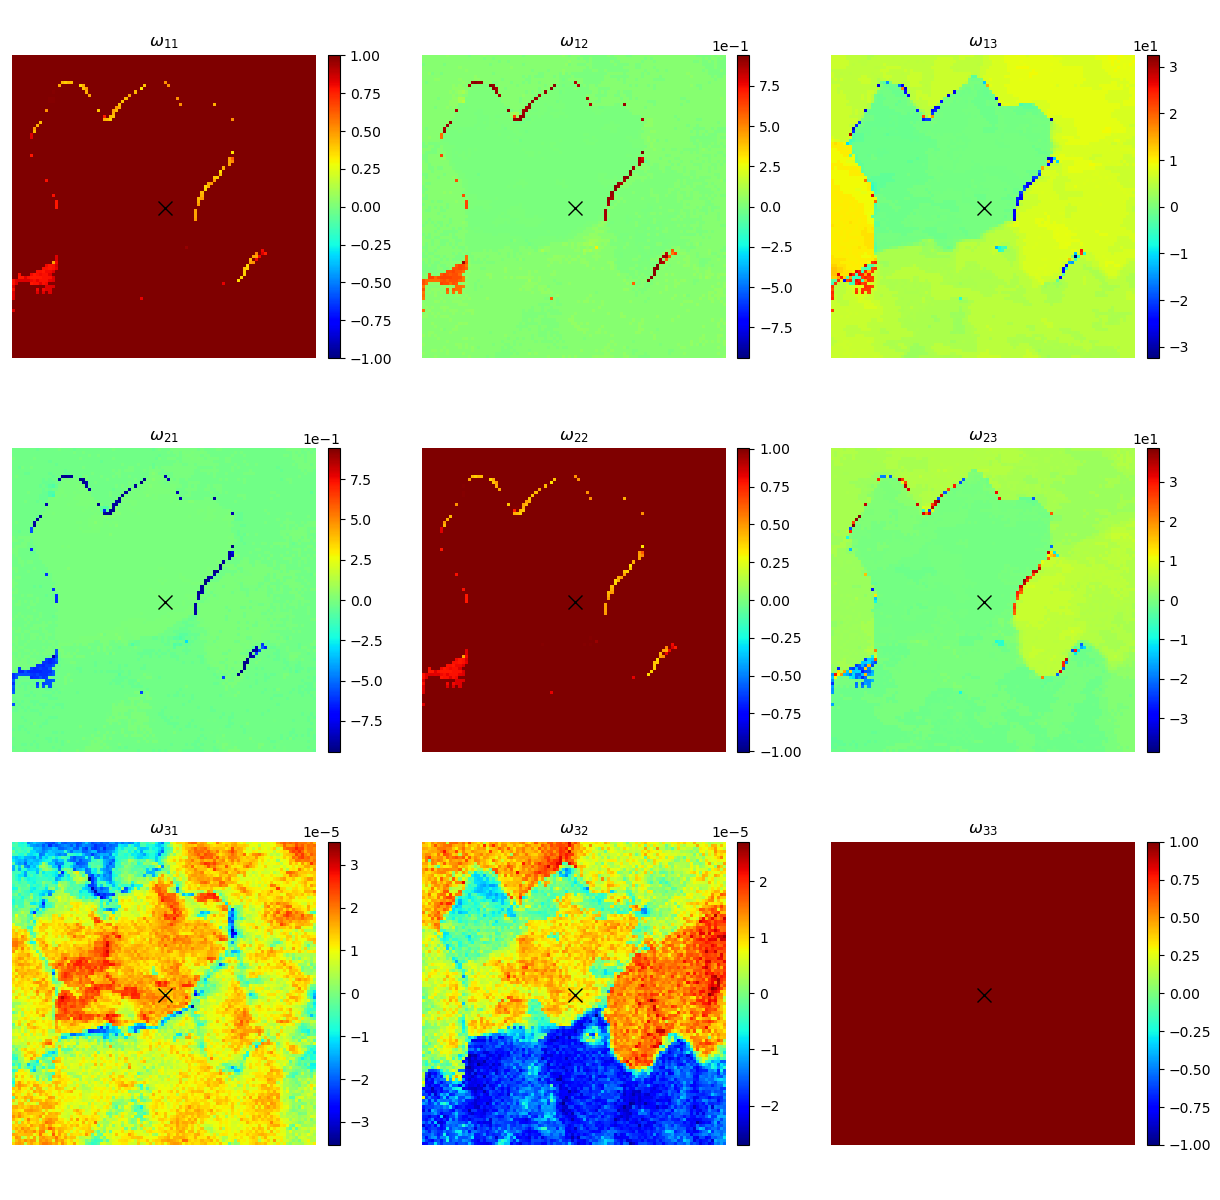

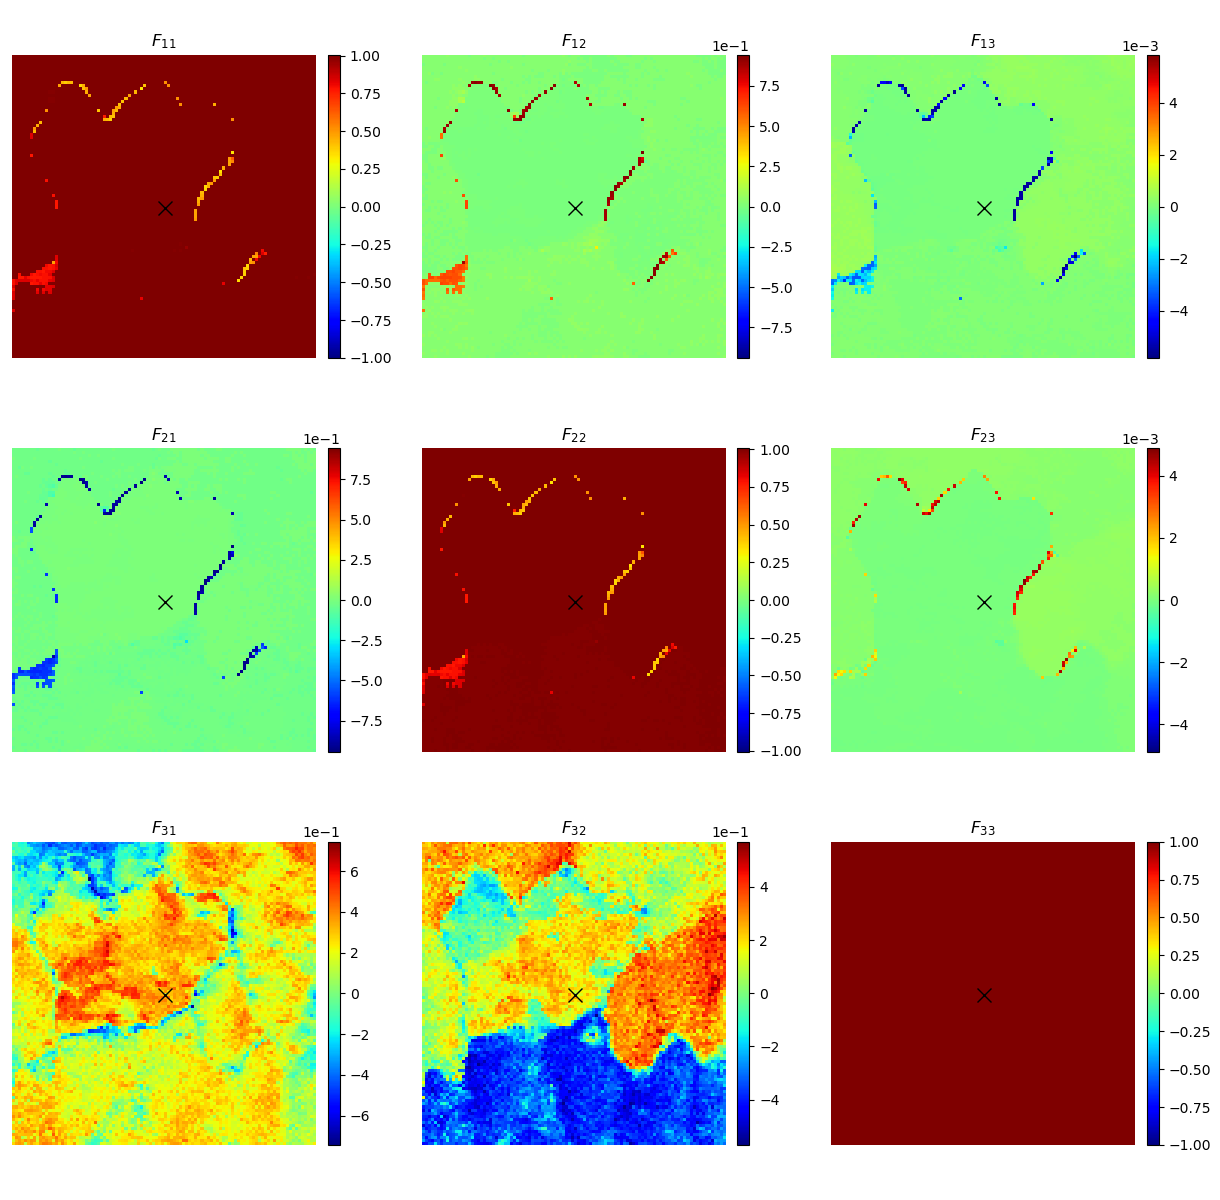

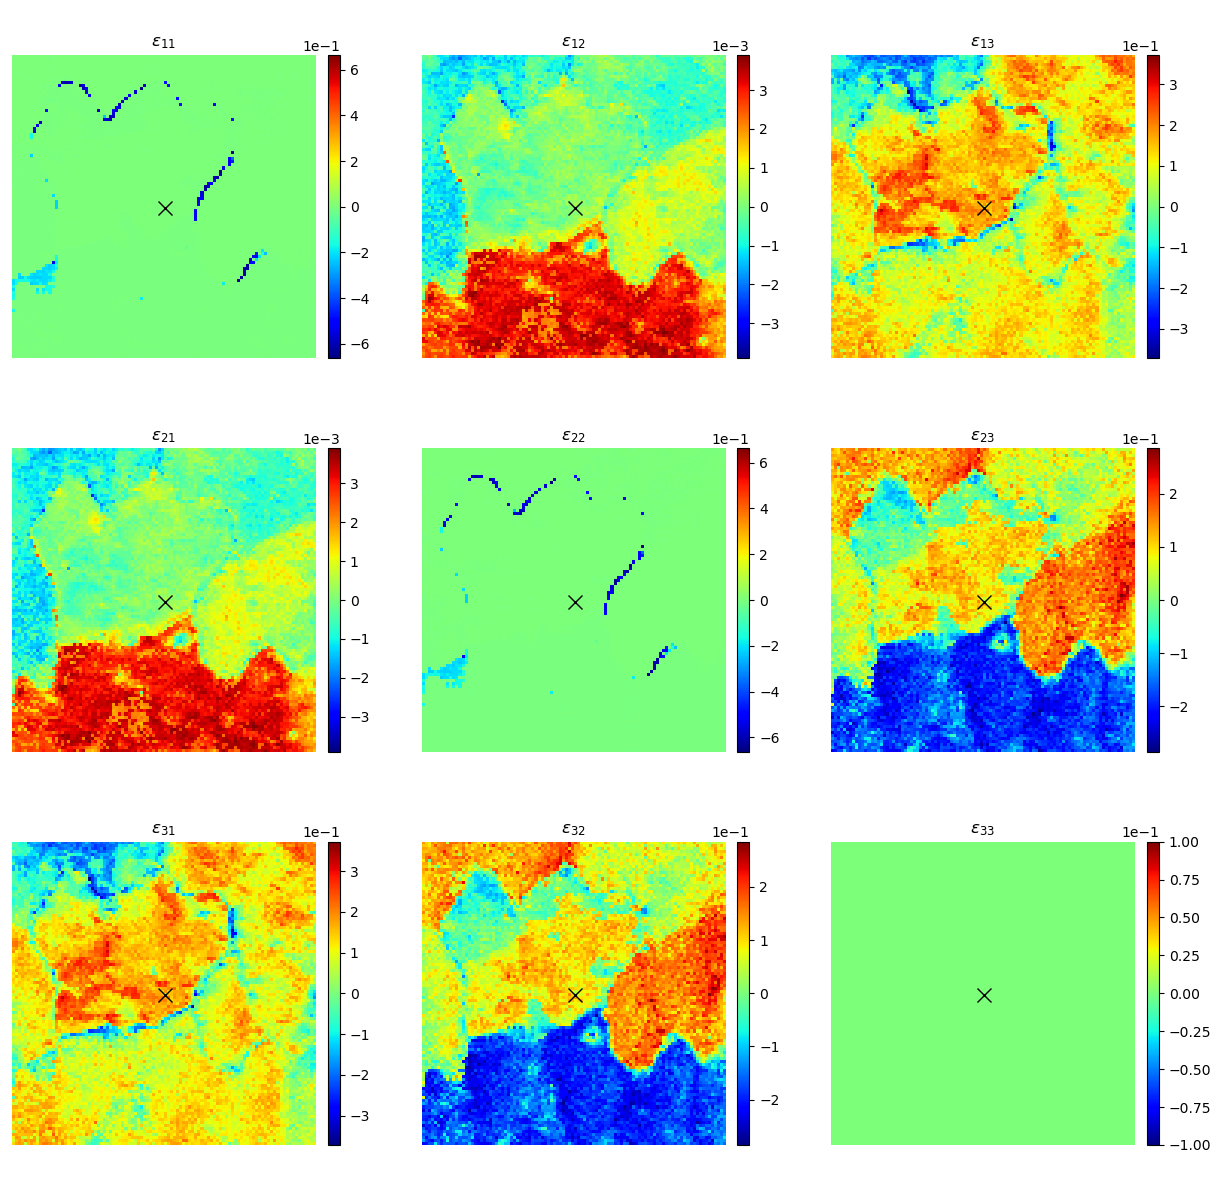

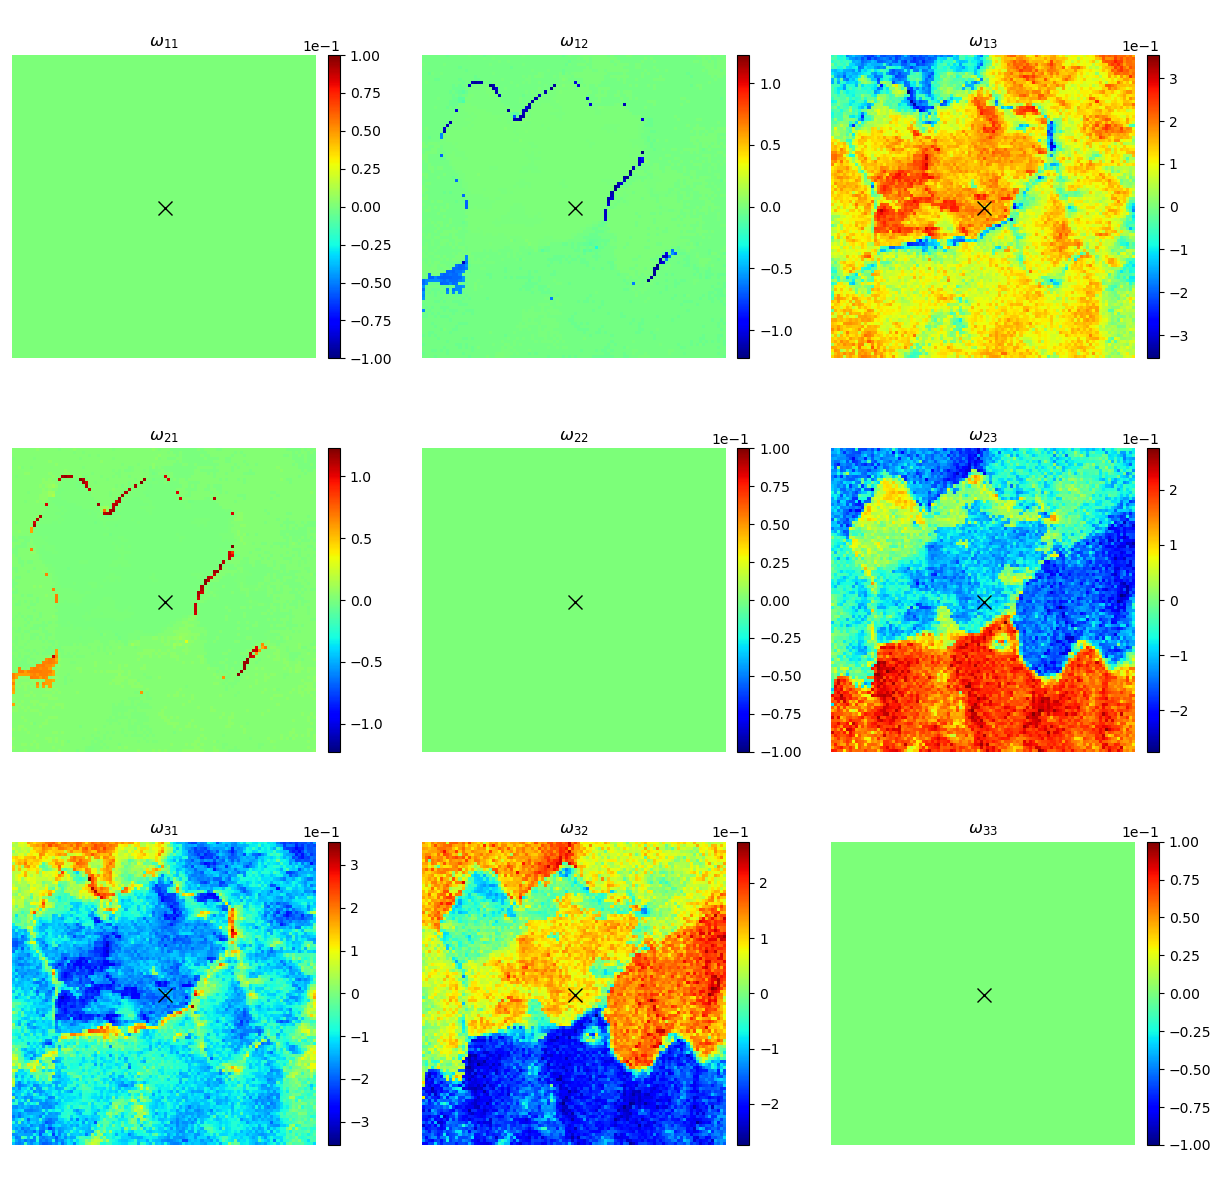

In [8]:
def view_tensor_images(e, cmap="jet", tensor_type="strain", xy=None):
    if tensor_type == "strain":
        var = r"$\epsilon$"
    elif tensor_type == "rotation":
        var = r"$\omega$"
    elif tensor_type == "deformation":
        var = r"$F$"
    fig, ax = plt.subplots(3, 3, figsize=(12.2, 12))
    plt.subplots_adjust(wspace=0.35, hspace=0.01, left=0.01, right=0.93, top=0.99, bottom=0.01)
    for i in range(3):
        for j in range(3):
            _0 = ax[i, j].imshow(e[..., i, j], cmap=cmap, vmin=-abs(e[..., i, j]).max(), vmax=abs(e[..., i, j]).max())
            ax[i, j].axis('off')
            ax[i, j].set_title(var + r"$_{%i%i}$" % (i+1, j+1))
            if xy is not None:
                ax[i, j].plot(xy[1], xy[0], 'kx', markersize=10)
            loc = ax[i, j].get_position()
            cax = fig.add_axes([loc.x1 + 0.01, loc.y0, 0.01, loc.height])
            # cax.ticklabel_format(style='sci', axis='y', useOffset=False, scilimits=(0, 0))
            cbar = fig.colorbar(_0, cax=cax, orientation='vertical')
            cbar.formatter.set_powerlimits((-1, 1))
    plt.show()

name = "r112-96-small"
xy = (50, 50)
plt.close('all')
view_tensor_images(W0, tensor_type="rotation", xy=xy)
plt.savefig(f"results/p0_{name}.png", dpi=300, bbox_inches='tight')

plt.close('all')
view_tensor_images(W, tensor_type="rotation", xy=xy)
plt.savefig(f"results/p_{name}.png", dpi=300, bbox_inches='tight')

plt.close('all')
view_tensor_images(Fe, tensor_type="deformation", xy=xy)
plt.savefig(f"results/Fe_{name}.png", dpi=300, bbox_inches='tight')

plt.close('all')
view_tensor_images(e, tensor_type="strain", xy=xy)
plt.savefig(f"results/e_{name}.png", dpi=300, bbox_inches='tight')

plt.close('all')
view_tensor_images(w, tensor_type="rotation", xy=xy)
plt.savefig(f"results/w_{name}.png", dpi=300, bbox_inches='tight')